In [1]:
#importing libraries

from decay_model.utility_functions import data_augmentation_functions_new
from tqdm.notebook import tqdm
from probeinterface.plotting import plot_probe
from decay_model.utility_functions import clustering_plotting_functions

import numpy as np
import matplotlib.pyplot as plt
import h5py
#import wandb
import matplotlib as mpl

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeextractors as see
import spikeinterface.comparison as sc
import MEArec as mr

from sklearn.mixture import GaussianMixture
from sklearn import decomposition
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from collections import defaultdict
from spikeinterface.sortingcomponents.peak_localization import localize_peaks


In [2]:
recording_directory = '/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/'
recording_name = 'recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13-31-005.h5'
save_directory = '/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/save files 3/'

#
width = 40 # The distance from the channel with the largest amplitude spike for which channels are included in the constructed data (microns).
spike_jitter = 5 # The number of frames used to align the extracted waveforms. We search within +-5 frames of the ground truth spike time to find the true peak.
amp_jitter = 0 # The amplitude jitter hyperparameter (described in the manuscript)
save = True # Save the dataset to the save_directory if True

In [3]:
file_name = recording_directory + recording_name
print(file_name)
recgen = mr.load_recordings(file_name)
soma_positions = [st.annotations['soma_position'] for st in recgen.spiketrains]

recording, sorting = se.read_mearec(file_name)

/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13-31-005.h5


In [4]:
st.get_noise_levels(recording).mean()

12.809522

In [8]:
st.get_noise_levels(recording_f).mean()

7.3039923

In [9]:
st.get_noise_levels(recording_notch).mean()

7.230582

In [10]:
st.get_noise_levels(recording_cmr).mean()

6.7436733

In [11]:
noise_raw = np.round(st.get_noise_levels(recording).mean(),2)
noise_raw

12.81

NotchFilterRecording: 100 channels - 1 segments - 32.0kHz - 60.000s
Use cache_folder=/var/folders/yh/nyq5m3zj111bg647cmllz8s00000gn/T/spikeinterface_cache/tmpntcw_vrt/I07GJ7AD
write_binary_recording with n_jobs 1  chunk_size None
BinaryRecordingExtractor: 100 channels - 1 segments - 32.0kHz - 60.000s
  file_paths: ['/var/folders/yh/nyq5m3zj111bg647cmllz8s00000gn/T/spikeinterface_cache/tmpntcw_vrt/I07GJ7AD/traces_cached_seg0.raw']


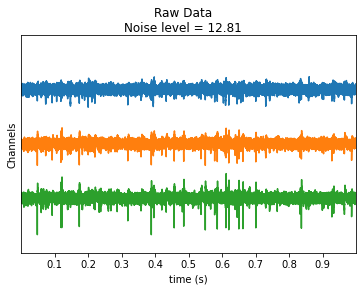

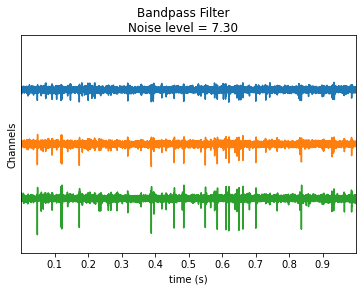

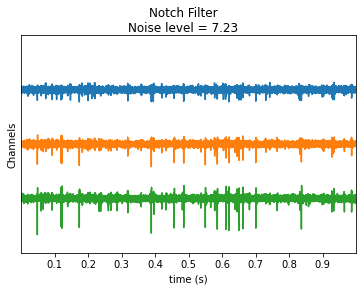

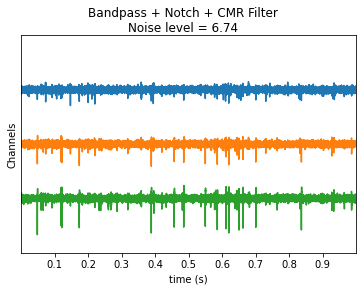

In [7]:
#Raw data plotting
w_raw = sw.plot_timeseries(recording, channel_ids=['1', '2', '3'])
w_raw.figure.suptitle("Raw Data\nNoise level = {:.2f}".format(st.get_noise_levels(recording).mean()))
w_raw.ax.set_ylabel('Channels')

recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)
#print(recording_f)
# Looking at the data after bandpass filter
w = sw.plot_timeseries(recording_f, channel_ids=['1', '2', '3'])
w.figure.suptitle("Bandpass Filter\nNoise level = {:.2f}".format(st.get_noise_levels(recording_f).mean()))
w.ax.set_ylabel('Channels')

recording_notch = st.notch_filter(recording_f, freq=2000, q=30)
print(recording_notch)
w_notch = sw.plot_timeseries(recording_notch, channel_ids=['1', '2', '3'])
w_notch.figure.suptitle("Notch Filter\nNoise level = {:.2f}".format(st.get_noise_levels(recording_notch).mean()))
w_notch.ax.set_ylabel('Channels')

recording_cmr = st.common_reference(recording_notch, reference='global', operator='median')
#print(recording_cmr)
# We can also apply other preprocessing steps to further increase the quality of the recording. 
# Common Median Reference (CMR)
w_cmr = sw.plot_timeseries(recording_cmr, channel_ids=['1', '2', '3'])
w_cmr.figure.suptitle("Bandpass + Notch + CMR Filter\nNoise level = {:.2f}".format(st.get_noise_levels(recording_cmr).mean()))
w_cmr.ax.set_ylabel('Channels')

# this computes and saves the recording after applying the preprocessing chain
recording_preprocessed = recording_cmr.save(format='binary')
print(recording_preprocessed)

In [12]:
waveforms_extractor = si.WaveformExtractor.create(recording_preprocessed, sorting, 'waveforms new', remove_if_exists=True)
waveforms_extractor.set_params(ms_before=1, ms_after=1.5, max_spikes_per_unit=None)
waveforms_extractor.run_extract_waveforms(n_jobs=-1, chunk_size=30000, progress_bar=True)
print(waveforms_extractor)

extract waveforms memmap: 100%|█████████████████| 64/64 [00:45<00:00,  1.41it/s]

WaveformExtractor: 100 channels - 50 units - 1 segments
  before:32 after:48 n_per_units:None


(80, 100)
(80, 100)
(80, 100)


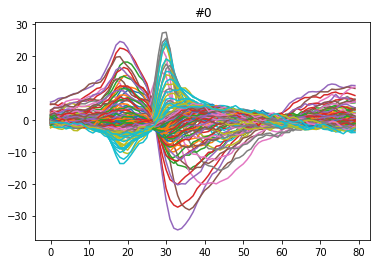

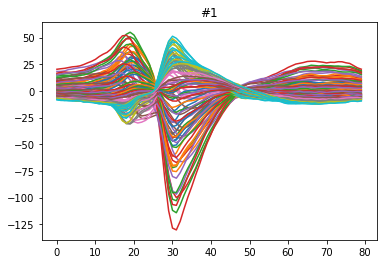

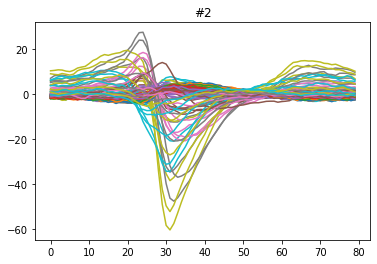

In [13]:
for unit_id in sorting.unit_ids[:3]:
    fig, ax = plt.subplots()
    template = waveforms_extractor.get_template(unit_id=unit_id, mode='median')
    print(template.shape)
    ax.plot(template)
    ax.set_title(f'{unit_id}')

plt.show()

In [14]:
job_kwargs = dict(chunk_duration='1s', n_jobs=-1, progress_bar=True)

peaks = st.get_peaks_from_templates(
    waveforms_extractor,
    peak_sign="neg",
    radius_um=20,
    **job_kwargs,
)

compute waveform features: 100%|███████████████| 60/60 [00:00<00:00, 588.67it/s]


In [15]:
width_dist_channels = st.get_channel_distances(recording_preprocessed)

In [16]:
channel_positions = np.asarray(recording.get_channel_locations())
channel_positions = np.concatenate((np.zeros((100,1)),channel_positions), 1)

sorted_widths = np.unique(np.sort(channel_positions[:,1]))
buffer_height = sorted_widths[-1] + (-sorted_widths[0]) + (sorted_widths[-1] - sorted_widths[-2])
sorted_heights = np.unique(np.sort(channel_positions[:,2]))
buffer_width = sorted_heights[-1] + (-sorted_heights[0]) + (sorted_heights[-1] - sorted_heights[-2])

padded_channel_list = list(channel_positions)
for i in range(-1, 2):
    for j in range(-1, 2):
        if((i,j) != (0,0)):
            buffer_channel_y = channel_positions[:,1] + buffer_height*i
            buffer_channel_z = channel_positions[:,2] + buffer_width*j
            channel_positions_copy = np.copy(channel_positions)
            channel_positions_copy[:,1] += buffer_height*i
            channel_positions_copy[:,2] += buffer_width*j
            padded_channel_list = padded_channel_list + list(channel_positions_copy)

padded_channel_positions = np.asarray(padded_channel_list)

In [17]:
amplitude = []
channel_locations = []
center_locations = []
waveforms_processed = []
spike_times = []
spike_ids = []
spike_id = 0

neuron_locations = []
neurons = []

for unit_id in tqdm(sorting.unit_ids):
    #neuron = unit_id    for herdingspike
    neuron = int(unit_id[1:])
    #short_waveforms = we_short_window.get_waveforms(unit_id)
    min_chans = peaks['channel_ind'][peaks['unit_ind']==neuron]
    #min_chans = np.argmin(np.min(short_waveforms, 1), -1)
    dist_chans = np.where(width_dist_channels[min_chans]<width)
    candidate_channels = [dist_chans[1][dist_chans[0]==i] for i in np.unique(dist_chans[0])]
    waveforms = np.moveaxis(waveforms_extractor.get_waveforms(unit_id),1,2)
    for waveform, chans, spike_time in zip(waveforms, candidate_channels, sorting.get_unit_spike_train(unit_id)):
        peak_frames, peak_channels, peak_amps = data_augmentation_functions_new.get_peak_events(waveform, chans, amp_jitter=amp_jitter,spike_jitter=spike_jitter)
        for peak_frame, peak_channel, peak_amp in zip(peak_frames, peak_channels, peak_amps):
            #Get a group of channels within the given width from the max channel
            square_channel_tuples, center_position = data_augmentation_functions_new.get_channel_square(peak_channel, padded_channel_positions, width=width)
            new_soma_pos = soma_positions[neuron] - center_position
            #Construct augmented data dataset with virtual and real channels (take min of each real channel (jitter around peak))
            amps = []
            locations = []
            channel_waveforms = []
            #If all waveforms are positive, we discard the event (this happens incredibly rarely in ground truth data and almost never in real data).
            if(peak_amp < 0):
                for sct in square_channel_tuples:
                    channel = sct[0]
                    if(channel < channel_positions.shape[0]):
                        #Real channel
                        observed = 1
                        #Get min peak within the spike jitter around the frame where the true minimum occurred
                        min_peak = np.min(waveform[channel, peak_frame - spike_jitter:peak_frame + spike_jitter]) 
                        peak_reading = min_peak
                        channel_waveforms.append(waveform[channel,:])
                    else:
                        #Virtual channel
                        observed = 0
                        #Virtual reading
                        peak_reading = 0
                        channel_waveforms.append(np.zeros(len(waveform[0,:])))
                    #Calculate relative location compared to center position for channel
                    locations.append(padded_channel_positions[channel] - center_position)
                    #Construct augmented amplitudes for channel
                    amps.append((peak_reading, observed))
                
                #Model data
                waveforms_processed.append(channel_waveforms)
                amplitude.append(amps)
                channel_locations.append(locations)
                center_locations.append(list(center_position))
                spike_times.append(spike_time)
                spike_ids.append(spike_id)

                #Label data
                neuron_locations.append(list(new_soma_pos))
                neurons.append(neuron)

            else:
                pass    
        spike_id += 1
        
# ################################################################################## Save augmented data
if(save):
    channel_string = str(width) +"um"
    train_path = save_directory + 'model_data_gt_'+ channel_string + '_VAE_'+str(amp_jitter)+'_amp_jitter_' + recording_name
    #Training data
    hf_train = h5py.File(train_path, 'w')
    hf_train.create_dataset('amplitude', data=amplitude)
    hf_train.create_dataset('channel_locations', data=channel_locations)
    hf_train.create_dataset('waveforms', data=waveforms_processed)
    hf_train.create_dataset('center_locations', data=center_locations)
    hf_train.create_dataset('spike_times', data=spike_times)
    hf_train.create_dataset('spike_ids', data=spike_ids)
    hf_train.close()

    #Training Labels
    label_path = save_directory + 'label_data_gt_' + channel_string + '_VAE_'+str(amp_jitter)+'_amp_jitter_' + recording_name
    hf_label = h5py.File(label_path, 'w')
    hf_label.create_dataset('neuron_locations', data=neuron_locations)
    hf_label.create_dataset('neurons', data=neurons)
    hf_label.close()

    print("Train Path: " + train_path)
    print("Label Path: " + label_path)

  0%|          | 0/50 [00:00<?, ?it/s]

Train Path: /Users/zelihasag/All Files/Edinburgh Courses/Dissertation/save files 3/model_data_gt_40um_VAE_0_amp_jitter_recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13-31-005.h5
Label Path: /Users/zelihasag/All Files/Edinburgh Courses/Dissertation/save files 3/label_data_gt_40um_VAE_0_amp_jitter_recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13-31-005.h5


In [18]:
min_chans = peaks['channel_ind'][peaks['unit_ind']==5]
min_chans

array([36, 36, 36, 36, 36, 36, 36, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 26, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 35,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 35, 36, 36,
       36, 36, 36, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 35, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 35, 36, 36, 36, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 35,
       36, 36, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 35, 35, 36,
       36, 36, 36, 36, 36, 36, 35, 36, 36, 36, 36, 36, 36, 35, 36, 36, 36,
       35, 36, 36, 35, 36, 36, 35, 36, 36, 36, 36, 36, 36, 36, 36, 35, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 35, 35, 35, 36, 36,
       36, 36, 36, 36, 36